# Advanced Natural Processing
---
## Assignment 1

#### Tejasvi Chebrolu
#### 2019114005

### Word Vectors Using SVD



## Import Statements
---

- `json` to deal with the json files.
- `re` for regular expressions.
- `numpy`, `scipy` for matrix calculation.
- `tqdm` to for checking progress .
- `TruncatedSVD`, 'TSNE' to do the SVD and for reducing the dimension space.
- `pyplot` for visualizing the vectors in 2-dimensions.


In [1]:
import json
import re
import numpy as np
from scipy import sparse
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from google.colab import drive

## Loading The Dataset
---

The dataset is loaded as a json file.


In [2]:
def get_data_from_json(path):
  data = []
  f = open(path)
  for a in f:
    data.append(json.loads(a))
  return data

## Mounting The Drive
---

The dataset is on google drive and hence needs to be mounted.

In [3]:
def mount_drive():
  drive.mount('/content/drive')

## Data Preprocessing
---

The data was cleaned as follows:
- Everything was converted into lowercase.
- Punctuations were removed from the data.
- Start and End tags were added to the the beginning and the end of every review.

Lists containing the words, and the sentences were returned.

In [4]:
def clean_data(data, length):
  punctuations='''!()-[]{};:'"\,<>./?@#$%^&*_~+='''
  final_text = []
  docs = []
  for a in tqdm(data[:length]):
    text = (a['reviewText']).lower()
    for x in text:
      if x in punctuations:
        text = text.replace(x, " ")
    sentence = ['<S>'] + text.split() + ['</S>']
    docs.append(sentence)
    for word in sentence:
      final_text.append(word)
  
  return final_text, docs

## Indexing Variables
---

All the unique words were given an index for further use.

In [5]:
def assign_words_a_number(text):
  unique_words = list(set(text))
  unique_dict = {}
  for i in range(len(unique_words)):
    unique_dict[unique_words[i]] = i
  return unique_words, unique_dict

## Co-Occurence Matrix Construction
---

The co-occurence matrix was constructed.

In [6]:
def create_covariance_matrix(docs, window):
  covariance_matrix = np.zeros((len(unique_words), len(unique_words)))
  for sentence in docs:
    for i in range(len(sentence)):
      for w in range(window):
        if i - 1 - w >= 0:
          covariance_matrix[unique_dict[sentence[i]]][unique_dict[sentence[(i - 1 - w)]]] += 1
        if i + 1 + w < len(sentence):
          covariance_matrix[unique_dict[sentence[i]]][unique_dict[sentence[(i + 1 + w)]]] += 1
  return covariance_matrix

## Running SVD
---

SVD was run on the matrix.

In [7]:
def SVD(matrix, dimensions, n_iters):
  SVD = TruncatedSVD(n_components=dimensions, n_iter=n_iters)
  M_reduced = SVD.fit_transform(matrix)
  return M_reduced

## t-SNE
---

The matrix is reduced to two dimensions after SVD.

In [8]:
def shift_dimensions(matrix, new_dimensions):
  Y = TSNE(n_components=new_dimensions, random_state=2).fit_transform(matrix)
  return Y[:, 0], Y[:, 1]

## Euclidean Distance
---

Function to find the Euclidean distance between two vectors.

In [9]:
def distance(x_coords, y_coords, original_index, required_index):
  return abs((float(x_coords[original_index]) - float(x_coords[required_index]))**2 - (float(y_coords[original_index]) - float(y_coords[required_index]))**2)

## Closest `n` Vectors For A Vector
---

Function that returns the closest `n` words given a word.

In [10]:
def find_closest_words(word, number):
  closest = {}
  index = unique_dict[word]
  for i in range(len(unique_words)):
    closest[reverse_dict[i]] = distance(x_coords, y_coords, index, i)
  sorted_dict = {k: v for k, v in sorted(closest.items(), key=lambda item: item[1])}
  return list(sorted_dict.keys())[:number]

## Reverse Dictionary
---

Function to invert keys and pairs.

In [11]:
def reverse_dict(old_dict):
  new_dict = {}
  for key in old_dict:
    new_dict[old_dict[key]] = key
  return new_dict

## Entry Point
---

In [12]:
mount_drive()
data = get_data_from_json('/content/drive/MyDrive/Electronics_5.json')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
all_text, docs = clean_data(data, 7000)

100%|██████████| 7000/7000 [00:00<00:00, 14720.23it/s]


In [14]:
unique_words, unique_dict = assign_words_a_number(all_text)

In [15]:
WINDOW = 2
VOCABULARY = len(unique_words)
EPOCHS = 10
DIMENSION = 100
REDUCED_DIMENSION = 2
NUM_MOST_SIMILAR_WORDS = 11

print("HYPERPARAMETERS:")
print("-" * 20)
print("VOCABULARY SIZE: ", VOCABULARY)
print("EPOCHS: ", EPOCHS)
print("EMBEDDING DIMENSION: ", DIMENSION)

HYPERPARAMETERS:
--------------------
VOCABULARY SIZE:  20692
EPOCHS:  10
EMBEDDING DIMENSION:  100


In [16]:
covariance_matrix = create_covariance_matrix(docs, WINDOW)

## Final Vectors
---


In [17]:
M_reduced = SVD(covariance_matrix, DIMENSION, EPOCHS)
print(M_reduced)

[[ 8.78976604e-01 -7.68900046e-01 -3.47440362e-01 ... -5.53419091e-02
   4.58323307e-02 -2.46265370e-02]
 [ 9.70749751e-02  3.35407450e-02  1.38258658e-02 ...  7.23737163e-02
  -3.24118941e-02 -2.07486731e-02]
 [ 6.11131246e-01 -4.76378442e-01 -4.79482439e-01 ... -1.77321090e-02
   5.52291534e-03  2.61369188e-02]
 ...
 [ 9.98381996e+01  5.46533584e+00 -2.40894685e+01 ... -4.60824393e-04
  -6.91714918e+00 -3.46139424e-02]
 [ 1.12882009e+00 -9.46711060e-01 -9.95268520e-01 ... -4.88738298e-02
  -1.92732178e-03  2.06700334e-02]
 [ 1.00023578e+00 -5.59676722e-02 -7.69411187e-01 ...  1.69279901e-01
   4.22029663e-02 -1.06523217e-02]]


In [18]:
x_coords, y_coords = shift_dimensions(M_reduced, REDUCED_DIMENSION)

## Visulisation
---

Visualising the words:
- monitor
- mounts
- put
- together
- samsung
- tv

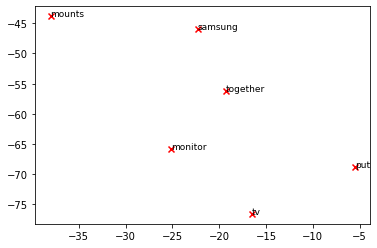

In [19]:
temp_words = ["monitor", "mounts", "put", "together", "samsung", "tv"]

for word in temp_words:
  coord = unique_dict[word]
  x = x_coords[coord]
  y = y_coords[coord]
  plt.scatter(x,y, marker='x', color='red')
  plt.text(x, y, word, fontsize=9)
plt.show()

In [20]:
reverse_dict = reverse_dict(unique_dict)

## Evaluating The Model

## The words chose are:

- laptop (noun)
- camera (noun)
- weak (verb)
- buy (verb)
- amazing(adjective)
- tv (noun)

The 10 closest words are printed for each of the word, along with the word included.

In [35]:
WORDS = ['laptop', 'camera', 'weak', 'buy', 'amazing', 'tv']
print("-" * 20)
for word in WORDS:
  cw = find_closest_words(word, NUM_MOST_SIMILAR_WORDS)
  print("The word is: ", word)
  print("-" * 20)
  for i, nw in enumerate(cw):
    if i == 0:
      continue
    print("{}. {}".format(i, nw))
  print("-" * 20)

--------------------
The word is:  laptop
--------------------
1. headphone
2. pc
3. home
4. ipod
5. ears
6. old
7. head
8. long
9. double
10. network
--------------------
The word is:  camera
--------------------
1. plug
2. device
3. thing
4. unit
5. radio
6. ear
7. case
8. corner
9. product
10. problem
--------------------
The word is:  weak
--------------------
1. loose
2. slightly
3. fairly
4. somewhat
5. extremely
6. faster
7. seconds
8. 40
9. otherwise
10. pearl
--------------------
The word is:  buy
--------------------
1. need
2. why
3. want
4. decided
5. re
6. are
7. wanted
8. always
9. find
10. do
--------------------
The word is:  amazing
--------------------
1. awesome
2. die
3. gives
4. true
5. fantastic
6. important
7. annoying
8. cool
9. slightly
10. markup
--------------------
The word is:  tv
--------------------
1. off
2. right
3. first
4. into
5. belkin
6. support
7. plug
8. phone
9. card
10. by
--------------------


## Saving The Model
---

In [22]:
vector_file = open('/content/drive/MyDrive/embeddings.txt', 'w')
vector_file.write('{} {}\n'.format(len(unique_dict), DIMENSION))
for i, vector in enumerate(M_reduced):
  vector_file.write('{} {}\n'.format(reverse_dict[i], vector))

___
